Importing Libraries

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from scipy import sparse
import warnings
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier



from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Functions

In [28]:

def load_dataset(dataset_path):
    dataset = pd.read_csv(dataset_path)
    return dataset

# Define a function to perform clustering and add cluster labels to the dataset
def perform_clustering(X, dataset, num_clusters=5):
    kmeans = KMeans(n_clusters=num_clusters)
    cluster_labels = kmeans.fit_predict(X)
    dataset['cluster_label'] = cluster_labels
    return dataset


# Define a function to run an algorithm on a dataset
def run_algorithm(X_train, X_test, y_train, y_test, algorithm):
    name, clf = algorithm
    if name == "Naive Bayes":
        X_train = convert_sparse_to_dense(X_train)
        y_train = convert_sparse_to_dense(y_train)
        clf.fit(X_train, y_train)
    else:
        clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    return name, accuracy, recall, precision, f1


def varEncoder(X):
    # string_columns = [col_idx for col_idx in range(X.shape[1]) if np.any([isinstance(item, str) for item in X[:, col_idx]])]
    string_columns = [col for col in X.columns if X[col].dtype == 'object']
    ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), string_columns)], remainder='passthrough')
    encoded_data = ct.fit_transform(X)
    return encoded_data

def labelEncoder(y):
    label_encoder = LabelEncoder()
    return label_encoder.fit_transform(y)

def convert_sparse_to_dense(array):
    for i in range(array.shape[0]):
        try:
            if sparse.issparse(array[i]):
                array[i] = array[i].toarray()
        except KeyError:
            print(f"", end="")
    return array

Dataset and Algorithms

In [29]:
datasets = [("/content/drive/MyDrive/MLproject/datasets/smoking.csv", "smoking"),
            ("/content/drive/MyDrive/MLproject/datasets/data.csv","Type"),
            ("/content/drive/MyDrive/MLproject/datasets/dataset.csv","Target"),
            ("/content/drive/MyDrive/MLproject/datasets/BankCustomerChurnPrediction.csv","churn"),
            ("/content/drive/MyDrive/MLproject/datasets/fetal_health.csv","fetal_health"),
            ("/content/drive/MyDrive/MLproject/datasets/heart_disease_health_indicators_BRFSS2015.csv","HeartDiseaseorAttack"),
            ("/content/drive/MyDrive/MLproject/datasets/heart.csv","target"),
            ("/content/drive/MyDrive/MLproject/datasets/oil_spill.csv","target"),
            ("/content/drive/MyDrive/MLproject/datasets/ParisHousingClass.csv","category"),
            ("/content/drive/MyDrive/MLproject/datasets/riceClassification.csv","Class"),
            ]

algorithms = [
    ("Decision Tree (Entropy)", DecisionTreeClassifier(criterion="entropy")),
    ("Decision Tree (Gini)", DecisionTreeClassifier(criterion="gini")),
    ("Naive Bayes", GaussianNB()),
    ("Random Forest", RandomForestClassifier(random_state=0, n_estimators=150)),
    ("Bagging (Decision Tree)", BaggingClassifier(base_estimator=DecisionTreeClassifier(), random_state=0, n_estimators=150)),
    ("Boosting (Decision Tree)", AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=0, n_estimators=150))
]

Training and Testing models

In [30]:
# Initialize arrays to store performance metrics data
algorithm_metrics = {algorithm[0]: {'accuracy_before': [], 'precision_before': [], 'recall_before': [], 'f1_before': [],
                                     'accuracy_after': [], 'precision_after': [], 'recall_after': [], 'f1_after': []}
                     for algorithm in algorithms}

# Loop through algorithms
for algorithm_name, classifier in algorithms:
    print(f"Running {algorithm_name}")
    # Loop through datasets
    for dataset_path, label_col_name in datasets:
        # Load the dataset
        dataset = load_dataset(dataset_path)

        # Separate features and labels
        # print(dataset_path)
        # print("\n")
        X = dataset.drop(label_col_name, axis=1)
        y = dataset[label_col_name]  # Specify the label column name here

        X = varEncoder(X)

        if all(isinstance(item, str) for item in y):
            y = labelEncoder(y)


        # Split data into training and testing sets (before clustering)
        X_train_before, X_test_before, y_train_before, y_test_before = train_test_split(X, y, test_size=0.2, random_state=1)

        # Run the algorithm before clustering
        name_before, accuracy_before, recall_before, precision_before, f1_before = run_algorithm(X_train_before, X_test_before, y_train_before, y_test_before, (algorithm_name, classifier))

        # Store the performance metrics before clustering
        algorithm_metrics[algorithm_name]['accuracy_before'].append(accuracy_before)
        algorithm_metrics[algorithm_name]['precision_before'].append(precision_before)
        algorithm_metrics[algorithm_name]['recall_before'].append(recall_before)
        algorithm_metrics[algorithm_name]['f1_before'].append(f1_before)

        # Perform clustering and add cluster labels
        dataset = perform_clustering(X, dataset)

        # Separate features and labels (after clustering)
        X_after = dataset.drop(label_col_name, axis=1)
        y_after = dataset[label_col_name]

        X_after = varEncoder(X_after)

        if all(isinstance(item, str) for item in y_after):
            y_after = labelEncoder(y_after)

        # Split data into training and testing sets (after clustering)
        X_train_after, X_test_after, y_train_after, y_test_after = train_test_split(X_after, y_after, test_size=0.2, random_state=0)

        # Run the algorithm after clustering
        name_after, accuracy_after, recall_after, precision_after, f1_after = run_algorithm(X_train_after, X_test_after, y_train_after, y_test_after, (algorithm_name, classifier))

        # Store the performance metrics after clustering
        algorithm_metrics[algorithm_name]['accuracy_after'].append(accuracy_after)
        algorithm_metrics[algorithm_name]['precision_after'].append(precision_after)
        algorithm_metrics[algorithm_name]['recall_after'].append(recall_after)
        algorithm_metrics[algorithm_name]['f1_after'].append(f1_after)

    print(f"Performance metrics for {algorithm_name} across datasets:")
    print(f"Accuracy: {algorithm_metrics[algorithm_name]['accuracy_before']}")
    print(f"Precision: {algorithm_metrics[algorithm_name]['precision_before']}")
    print(f"Recall: {algorithm_metrics[algorithm_name]['recall_before']}")
    print(f"F1 Score: {algorithm_metrics[algorithm_name]['f1_before']}")
    print("\n")

    print(f"Performance metrics for {algorithm_name} across datasets:")
    print(f"Accuracy: {algorithm_metrics[algorithm_name]['accuracy_after']}")
    print(f"Precision: {algorithm_metrics[algorithm_name]['precision_after']}")
    print(f"Recall: {algorithm_metrics[algorithm_name]['recall_after']}")
    print(f"F1 Score: {algorithm_metrics[algorithm_name]['f1_after']}")
    print("\n")

Running Decision Tree (Entropy)
Performance metrics for Decision Tree (Entropy) across datasets:
Accuracy: [0.7811293652931143, 0.825, 0.6949152542372882, 0.791, 0.9154929577464789, 0.8536147902869757, 0.7540983606557377, 0.9521276595744681, 1.0, 1.0]
Precision: [0.7809113167745643, 0.8341111111111111, 0.6909721634439508, 0.7876899500464337, 0.9142116869076727, 0.8591643350833073, 0.7542396834369701, 0.9503436820422035, 1.0, 1.0]
Recall: [0.7811293652931143, 0.825, 0.6949152542372882, 0.791, 0.9154929577464789, 0.8536147902869757, 0.7540983606557377, 0.9521276595744681, 1.0, 1.0]
F1 Score: [0.7810177454351899, 0.8177489177489179, 0.6928003742716856, 0.7892735226310488, 0.9146758971025672, 0.8563326664080398, 0.753966048770161, 0.9511547643693674, 1.0, 1.0]


Performance metrics for Decision Tree (Entropy) across datasets:
Accuracy: [0.769907532094443, 0.85, 0.6915254237288135, 0.791, 0.9295774647887324, 0.8560785241248817, 0.8032786885245902, 0.9680851063829787, 1.0, 0.9997250481165796

Visualizing results (Decision Trees)

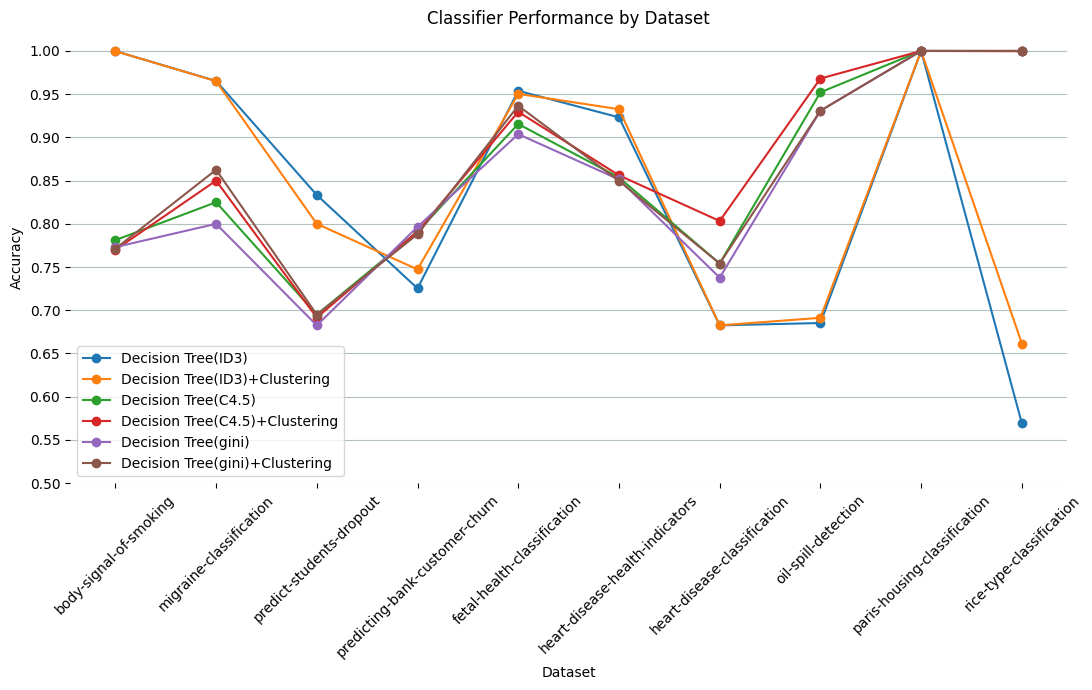

In [41]:
y_levels = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]

# Create a line plot using matplotlib
plt.figure(figsize=(11, 7))



# ("Decision Tree (Entropy)", DecisionTreeClassifier(criterion="entropy")),
#     ("Decision Tree (Gini)", DecisionTreeClassifier(criterion="gini")),
#     ("Naive Bayes", GaussianNB()),
#     ("Random Forest", RandomForestClassifier(random_state=0, n_estimators=150)),
#     ("Bagging (Decision Tree)", BaggingClassifier(base_estimator=DecisionTreeClassifier(), random_state=0, n_estimators=150)),
#     ("Boosting (Decision Tree)", AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=0, n_estimators=150))
dataset_names = ['body-signal-of-smoking', 'migraine-classification', 'predict-students-dropout', 'predicting-bank-customer-churn', 'fetal-health-classification', 'heart-disease-health-indicators', 'heart-disease-classification', 'oil-spill-detection', 'paris-housing-classification', 'rice-type-classification']

accuracy_values_dtId_before = [0.9998167155425219, 0.9652666666666667, 0.8333333333333334, 0.7252747252747253, 0.9539007092198581, 0.9231974921630094, 0.6825396825396826, 0.6852409638554217, 1.0, 0.5692307692307692]  # Accuracy values for Decision Tree
accuracy_values_dtId_after = [0.9998167155425219, 0.9650666666666666, 0.8, 0.7472527472527473, 0.950354609929078, 0.932601880877743, 0.6825396825396826, 0.6912650602409639, 1.0, 0.6615384615384615]#ues for Dt + clustering

y_levels = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]



# Plot lines for each classifier

plt.plot(dataset_names, accuracy_values_dtId_before, marker='o', label='Decision Tree(ID3)')
plt.plot(dataset_names, accuracy_values_dtId_after, marker='o', label='Decision Tree(ID3)+Clustering')
plt.plot(dataset_names, algorithm_metrics['Decision Tree (Entropy)']['accuracy_before'], marker='o', label='Decision Tree(C4.5)')
plt.plot(dataset_names, algorithm_metrics['Decision Tree (Entropy)']['accuracy_after'], marker='o', label='Decision Tree(C4.5)+Clustering')
plt.plot(dataset_names, algorithm_metrics['Decision Tree (Gini)']['accuracy_before'], marker='o', label='Decision Tree(gini)')
plt.plot(dataset_names, algorithm_metrics['Decision Tree (Gini)']['accuracy_after'], marker='o', label='Decision Tree(gini)+Clustering')
plt.grid(color='#95a5a6' , axis='y', alpha=0.7)





plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)


plt.ylabel('Accuracy')
plt.xlabel('Dataset')
plt.title('Classifier Performance by Dataset')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.yticks(y_levels)


plt.show()

Visualization of results (Naive Bayes and Random Forest)

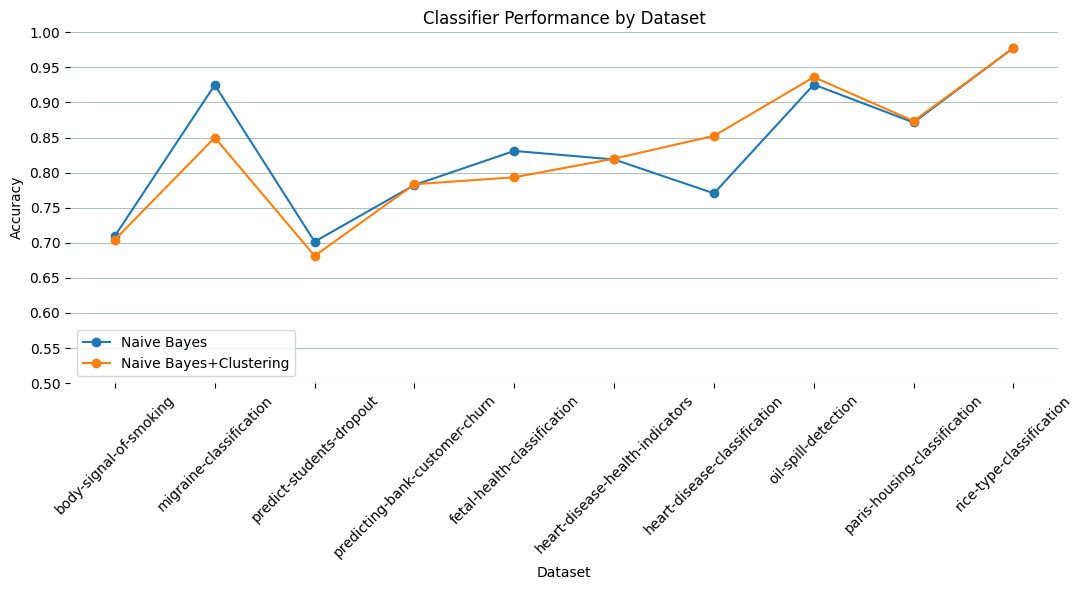

In [43]:
plt.figure(figsize=(11, 6))
plt.plot(dataset_names, algorithm_metrics['Naive Bayes']['accuracy_before'], marker='o', label='Naive Bayes')
plt.plot(dataset_names, algorithm_metrics['Naive Bayes']['accuracy_after'], marker='o', label='Naive Bayes+Clustering')

plt.grid(color='#95a5a6' , axis='y', alpha=0.7)





plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)


plt.ylabel('Accuracy')
plt.xlabel('Dataset')
plt.title('Classifier Performance by Dataset')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.yticks(y_levels)


plt.show()

Visualization of results (Bagging and boosting)

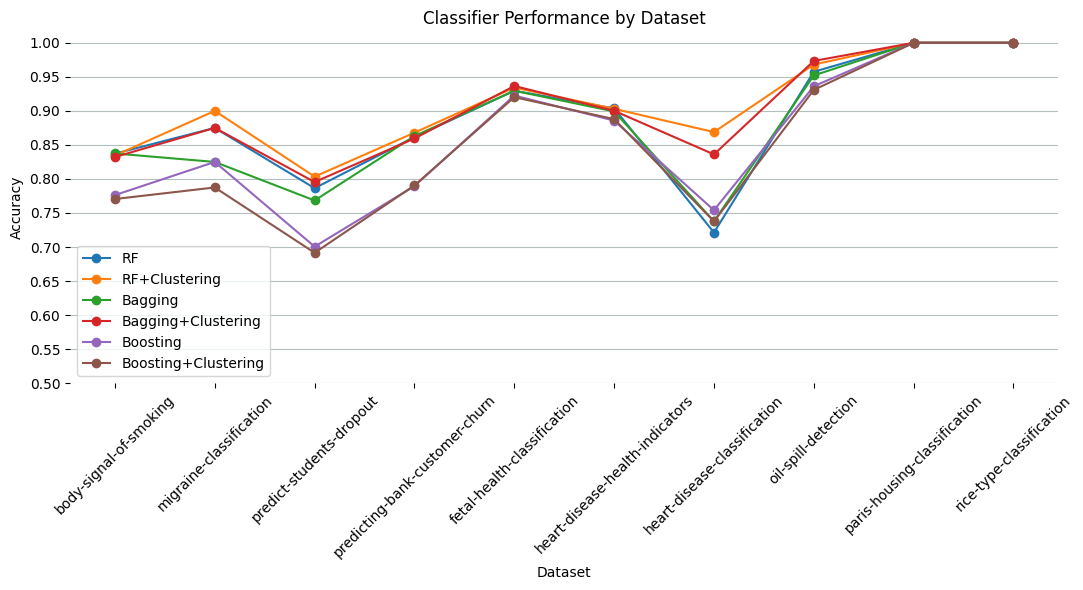

In [42]:
plt.figure(figsize=(11, 6))
plt.plot(dataset_names, algorithm_metrics['Random Forest']['accuracy_before'], marker='o', label='RF')
plt.plot(dataset_names, algorithm_metrics['Random Forest']['accuracy_after'], marker='o', label='RF+Clustering')
plt.plot(dataset_names, algorithm_metrics['Bagging (Decision Tree)']['accuracy_before'], marker='o', label='Bagging')
plt.plot(dataset_names, algorithm_metrics['Bagging (Decision Tree)']['accuracy_after'], marker='o', label='Bagging+Clustering')
plt.plot(dataset_names, algorithm_metrics['Boosting (Decision Tree)']['accuracy_before'], marker='o', label='Boosting')
plt.plot(dataset_names, algorithm_metrics['Boosting (Decision Tree)']['accuracy_after'], marker='o', label='Boosting+Clustering')
plt.grid(color='#95a5a6' , axis='y', alpha=0.7)





plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)


plt.ylabel('Accuracy')
plt.xlabel('Dataset')
plt.title('Classifier Performance by Dataset')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.yticks(y_levels)


plt.show()